Plot titrations curves

In [52]:
# python modules
import sys
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [53]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [54]:
### matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [55]:
### data path
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/titration_files/'


In [56]:
### parameters
agent_unit = {'sp':'mM',
              'spd':'mM',
              'CoH':'mM',
              'PEG':'%',
              'Mg':'mM',
              'Ca':'mM',
              'HP1a':'$\\mu$M',
              'HP1bSUV':'$\\mu$M'}

agent_logbase = {'sp':10,
                 'spd':10,
                 'CoH':10,
                 'PEG':None,
                 'Mg':None,
                 'Ca':None,
                 'HP1a':2,
                 'HP1bSUV':2}

agent_fullname = {'sp':'Spermine$^{4+}$',
                  'spd':'Spermidine$^{3+}$',
                  'CoH':'Cobalt Hexammine$^{3+}$',
                  'PEG':'PEG 8000',
                  'Mg':'Magnesium',
                  'Ca':'Calcium',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$/SUV39H1'}

In [85]:
### read titration file
def read_titration (fname,
                    full_reps=False):
    conc_list = []
    mean_list = []
    std_list = []

    if full_reps:
        fracs_list = []
    
    First = True
    for line in open(fname):
        if First:
            First = False
            continue
        if not line:
            continue
        cols = line.strip().split()
        conc, mean, std = float(cols[0]), float(cols[-3]), float(cols[-2])
        conc_list.append(conc)
        mean_list.append(mean)
        std_list.append(std)

        if full_reps:
            fracs = [float(value) for value in cols[4:7]]
            fracs_list.append(fracs)

    if full_reps:
        return conc_list, mean_list, std_list, fracs_list
    
    return conc_list, mean_list, std_list


In [58]:
### plot titration curve
def plot_titration_curve (rexp_list,
                          agent,
                          labels,
                          colors,
                          title=None,
                          figsize=(2.4,1.8),
                          note='',
                          show=True,
                          save_path='./',
                          save=False):

    fig = plt.figure(figsize=figsize)

    for i in range(len(rexp_list)):
        cell, sample, agent = rexp_list[i]
        fname = path + '_'.join([cell, sample, agent, 'titration']) + '.csv'
        conc_list, mean_list, std_list = read_titration (fname)

        if agent_logbase[agent] != None:
            conc_list = conc_list[1:]
            mean_list = mean_list[1:]
            std_list = std_list[1:]

        label, color = labels[i], colors[i]

        if color.startswith('tab'):
            ecolor = color
        else:
            ecolor = 'tab:' + color

        plt.plot(conc_list,
                 mean_list,
                 'o-',
                 color=color,
                 lw=1.5,
                 markersize=3.5,
                 label=label)
        
        plt.errorbar(conc_list,
                     mean_list,
                     yerr=std_list,
                     fmt='.',
                     markersize=3.5,
                     mfc=color,
                     mec=color,
                     lw=1.5,
                     color=ecolor,
                     alpha=0.8)

    if agent_logbase[agent] != None:
        plt.xscale("log", basex=agent_logbase[agent])

    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.gca().tick_params(axis='both', which='minor', labelsize=8)
    plt.xlabel("%s concentration (%s)" % (agent_fullname[agent], agent_unit[agent]),
               fontsize=11)
    plt.ylabel("Soluble fraction", fontsize=11)
    plt.title(title, fontsize=13)
    plt.legend(fontsize=8)
    if save:
        plt.savefig(save_path + 'titration_%s.svg' % (note),
                    format='svg',
                    bbox_inches='tight')
    if show:
        plt.show()
    plt.close()    

    

In [120]:
### plot statistical importances
def plot_stat (rexp_list,
               agent,
               labels,
               figsize=(2.4,1.8),
               note='',
               show=True,
               save_path='./',
               save=False):

    # read titration files
    rexp_conc_list = {}
    rexp_fracs_list = {}
    for i in range(len(rexp_list)):
        rexp = rexp_list[i]
        cell, sample, agent = rexp
        fname = path + '_'.join([cell, sample, agent, 'titration']) + '.csv'
        conc_list, mean_list, std_list, fracs_list = read_titration (fname, full_reps=True)
        rexp_conc_list[rexp] = conc_list
        rexp_fracs_list[rexp] = fracs_list

    # compute pair-wise pvalue and CohenD
    pair_conc_list = {}
    pair_pvalue_list = {}
    pair_CohenD_list = {}
    for i in range(len(rexp_list)-1):
        for j in range(i+1, len(rexp_list)):
            rexp1, rexp2 = rexp_list[i], rexp_list[j]
            conc_list1 = rexp_conc_list[rexp1]
            fracs_list1 = rexp_fracs_list[rexp1]
            conc_list2 = rexp_conc_list[rexp2]
            fracs_list2 = rexp_fracs_list[rexp2]

            label1, label2 = labels[i], labels[j]
            #print label1, label2

            conc_list = []
            pvalue_list = []
            CohenD_list = []
            for k in range(len(conc_list1)):
                conc1 = conc_list1[k]
                fracs1 = fracs_list1[k]
                conc2 = conc_list2[k]
                fracs2 = fracs_list2[k]

                assert conc1 == conc2

                if agent_logbase[agent] != None and k ==0:
                    continue

                #print fracs1
                #print fracs2
                pvalue = stats.ttest_ind(fracs1,
                                         fracs2,
                                         equal_var=False)[1]
                #print 'here'

                CohenD = statis.get_CohenD (fracs1, fracs2)

                #print conc1, pvalue, CohenD

                conc_list.append(conc1)
                pvalue_list.append(pvalue)
                CohenD_list.append(CohenD)

            pair = (label1, label2)
            pair_conc_list[pair] = conc_list
            pair_pvalue_list[pair] = pvalue_list
            pair_CohenD_list[pair] = CohenD_list


    #plot pair-wise pvalue and Cohen's d

    for pair in pair_conc_list:
        conc_list = pair_conc_list[pair]
        pvalue_list = pair_pvalue_list[pair]
        CohenD_list = pair_CohenD_list[pair]
    
        fig, ax1 = plt.subplots(nrows=1,
                                ncols=1,
                                figsize=figsize)
        ax2 = ax1.twinx()

        #ax1.plot(conc_list,
        #         CohenD_list,
        #         'o-',
        #         color='tab:red',
        #         lw=1.5,
        #         markersize=3.5)

        ax2.plot(conc_list,
                 pvalue_list,
                 'o-',
                 color='tab:blue',
                 lw=1.5,
                 markersize=3.5)

        for conc, pvalue in zip(conc_list, pvalue_list):

            ax2.text(conc,
                     pvalue,
                     str(round(pvalue, 3)),
                     ha="center",
                     va="center",
                     fontsize=10,
                     weight='bold')

        ax2.axhline(y=0.05, linestyle='--', color='blue', alpha=0.5)

        if agent_logbase[agent] != None:
            plt.xscale("log", basex=agent_logbase[agent])

        ax1.tick_params(axis='both', which='major', labelsize=10)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        ax1.set_xlabel("%s concentration (%s)" % (agent_fullname[agent], agent_unit[agent]),
                      fontsize=11)
        
        #ax1.set_ylabel("Cohen's d", color='red', fontsize=11)
        #ax1.tick_params('y', colors='red')
        
        ax2.set_ylabel("p-value", color='blue', fontsize=11)
        ax2.tick_params('y', colors='blue')
        ax2.set_yscale('log', basey=10)

        ax1.set_title('%s VS %s' % pair , fontsize=13)
        
        if save:
            plt.savefig(save_path + 'titration_stat_%s.svg' % (note),
                        format='svg',
                        bbox_inches='tight')
        if show:
            plt.show()
        plt.close()    

            


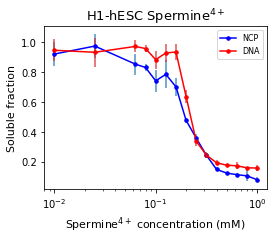

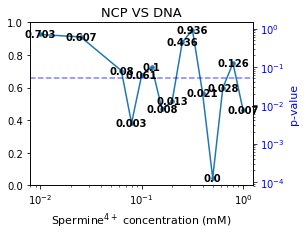

In [121]:
# H1-hESC data (spermine) [Fig. 1b]
rexp_list = [('H1', 'NCP', 'sp'),
             ('H1', 'DNA', 'sp')]
labels = ['NCP', 'DNA']
colors = ['blue', 'red']
agent = 'sp'
title = "H1-hESC %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='H1_sp')

plot_stat (rexp_list,
           agent,
           labels,
           figsize=(4,3),
           save_path='./data/',
           save=True,
           note='H1_sp')



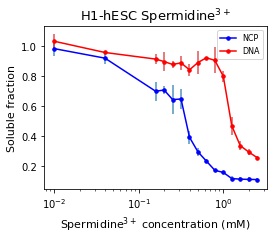

In [60]:
# H1-hESC data (spermidine) [Extended Data Fig. 8a]
rexp_list = [('H1', 'NCP', 'spd'),
             ('H1', 'DNA', 'spd')]
labels = ['NCP', 'DNA']
colors = ['blue', 'red']
agent = 'spd'
title = "H1-hESC %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='H1_spd')


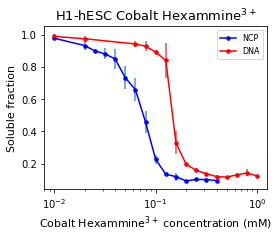

In [61]:
# H1-hESC data (CoH) [Extended Data Fig. 8a]
rexp_list = [('H1', 'NCP', 'CoH'),
             ('H1', 'DNA', 'CoH')]
labels = ['NCP', 'DNA']
colors = ['blue', 'red']
agent = 'CoH'
title = "H1-hESC %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='H1_CoH')


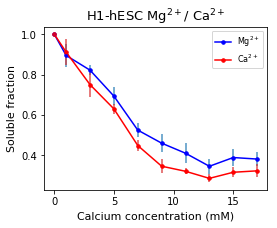

In [62]:
# H1-hESC data (Mg2+/Ca2+) [Extended Data Fig. 8a]
rexp_list = [('H1', 'NCP', 'Mg'),
             ('H1', 'NCP', 'Ca')]
labels = ['Mg$^{2+}$', 'Ca$^{2+}$']
colors = ['blue', 'red']
title = "H1-hESC Mg$^{2+}$/ Ca$^{2+}$"

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='H1_MgCa')


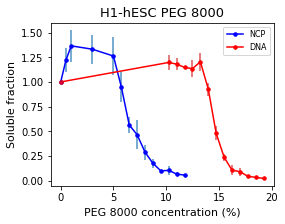

In [63]:
# H1-hESC data (PEG) [Extended Data Fig. 8a]
rexp_list = [('H1', 'NCP', 'PEG'),
             ('H1', 'DNA', 'PEG')]
labels = ['NCP', 'DNA']
colors = ['blue', 'red']
agent = 'PEG'
title = "H1-hESC %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data',
                      save=True,
                      note='H1_PEG')


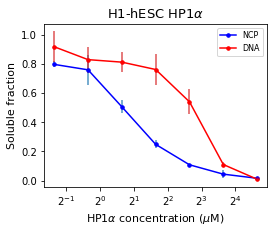

In [64]:
# H1-hESC data (HP1a) [Extended Data Fig. 8a]
rexp_list = [('H1', 'NCP', 'HP1a'),
             ('H1', 'DNA', 'HP1a')]
labels = ['NCP', 'DNA']
colors = ['blue', 'red']
agent = 'HP1a'
title = "H1-hESC %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='H1_HP1a')


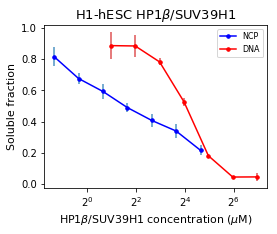

In [65]:
# H1-hESC data (HP1b/SUV) [Extended Data Fig. 8a]
rexp_list = [('H1', 'NCP', 'HP1bSUV'),
             ('H1', 'DNA', 'HP1bSUV')]
labels = ['NCP', 'DNA']
colors = ['blue', 'red']
agent = 'HP1bSUV'
title = "H1-hESC %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='H1_HP1bSUV')


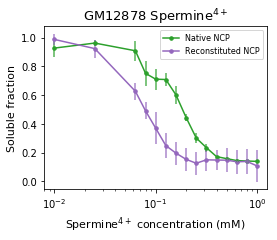

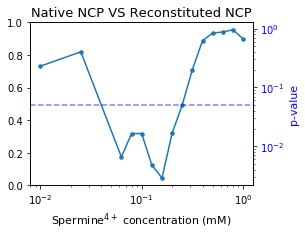

In [114]:
# GM data [Extended Data Fig. 7c]
rexp_list = [('GM', 'NCP', 'sp'),
             ('GM', 'synNCP', 'sp')]
labels = ['Native NCP', 'Reconstituted NCP']
colors = ['tab:green', 'tab:purple']
agent = 'sp'
title = "GM12878 %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='GM_NativeSyn')

plot_stat (rexp_list,
           agent,
           labels,
           figsize=(4,3),
           save_path='./data/',
           save=True,
           note='GM_NativeSyn')



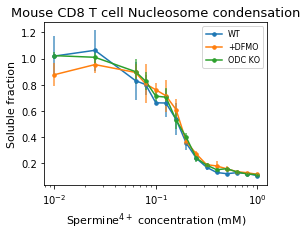

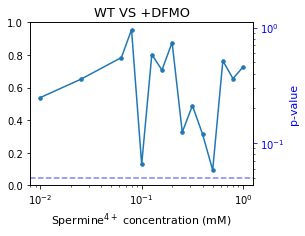

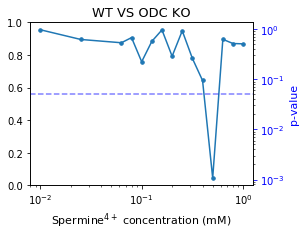

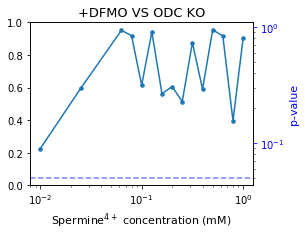

In [115]:
# mCD8T data [Extended Data Fig. 10a]
rexp_list = [('mCD8T:WT', 'NCP', 'sp'),
             ('mCD8T:DFMO', 'NCP', 'sp'),
             ('mCD8T:ODCKO', 'NCP', 'sp')]
labels = ['WT', '+DFMO', 'ODC KO']
colors = ['tab:blue', 'tab:orange', 'tab:green']
title = "Mouse CD8 T cell Nucleosome condensation"
agent = 'sp'

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='mCD8T_sp')

plot_stat (rexp_list,
           agent,
           labels,
           figsize=(4,3),
           save_path='./data/',
           save=True,
           note='mCD8T_sp')
                      


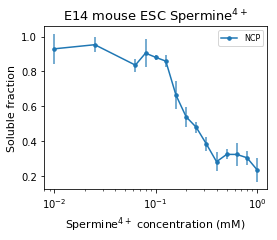

In [68]:
# mCD8T data [Extended Data Fig. 3d]
rexp_list = [('E14', 'NCPre3', 'sp')]
labels = ['NCP']
colors = ['tab:blue']
agent = 'sp'
title = "E14 mouse ESC %s" % (agent_fullname[agent])

plot_titration_curve (rexp_list,
                      agent,
                      labels,
                      colors,
                      title,
                      figsize=(4,3),
                      save_path='./data/',
                      save=True,
                      note='E14_sp')